# 1. Noisy 'fake' QPU in qiskit

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, transpile
import numpy as np

In [2]:
qc = QuantumCircuit(2)

In [3]:
# add Pauli X(Y,Z) gate at qubit 0

qc.x(0) # qc.y() for pauli y, qc.z() for pauli z

qc.draw()

┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────

In [4]:
# add Hadamard gate at qbuit 0

qc.h(0)
qc.draw()

┌───┐┌───┐
q_0: ┤ X ├┤ H ├
     └───┘└───┘
q_1: ──────────

In [5]:
# add CNOT for qubit(0,1)

qc.cx(0,1)
qc.draw()

┌───┐┌───┐     
q_0: ┤ X ├┤ H ├──■──
     └───┘└───┘┌─┴─┐
q_1: ──────────┤ X ├
               └───┘

In [6]:
# Add measurement to circuit
qc.measure_all()
qc.draw()

┌───┐┌───┐      ░ ┌─┐   
   q_0: ┤ X ├┤ H ├──■───░─┤M├───
        └───┘└───┘┌─┴─┐ ░ └╥┘┌─┐
   q_1: ──────────┤ X ├─░──╫─┤M├
                  └───┘ ░  ║ └╥┘
meas: 2/═══════════════════╩══╩═
                           0  1

In [7]:
from qiskit_aer import AerSimulator
# transpile circuit with noise
sim = AerSimulator()
# transpile with backend
tqc = transpile(qc,sim)
job_res = sim.run(tqc,shots=10000).result()
pop = job_res.get_counts()

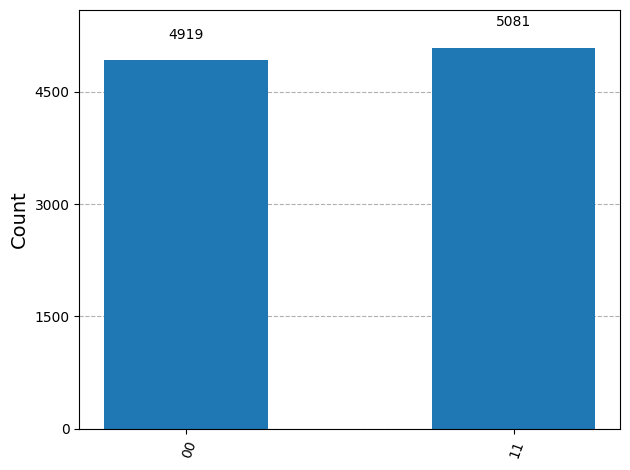

In [8]:
from qiskit.visualization import plot_histogram
plot_histogram(pop)

## Noise model

We can add nosie into simulator. We can introduce the noise model that mimics real quantum computer. There are different type of noise which can found in qiskit website.
\
https://docs.quantum.ibm.com/api/qiskit/0.24/aer_noise

In [9]:
from qiskit import QuantumCircuit
from qiskit import transpile
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import SamplerV2
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
 
# Get a fake backend from the fake provider
backend = FakeManilaV2()

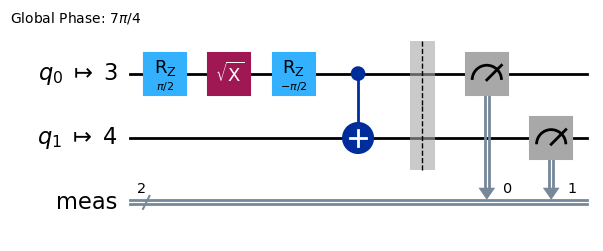

In [10]:
# Transpile the ideal circuit to a circuit that can be
# directly executed by the backend
transpiled_circuit = transpile(qc, backend)
transpiled_circuit.draw('mpl', style="iqp")

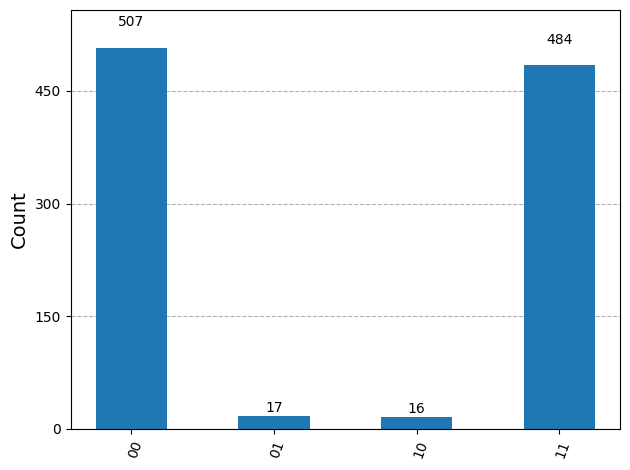

In [11]:
# Run the transpiled circuit using the simulated fake backend
sampler = SamplerV2(backend)
job = sampler.run([transpiled_circuit])
pub_result = job.result()[0]
counts = pub_result.data.meas.get_counts()
plot_histogram(counts)

# 2. Ramsey and spin echo experiments

In [12]:
qc = QuantumCircuit(1)

In [13]:
qc_echo=[]
delay=1
for i in range(0,10):
    qc_aux=QuantumCircuit(1)
    qc_aux.rx(np.pi/2,0)
    qc_aux.delay(delay)
    qc_aux.rx(np.pi,0)
    qc_aux.delay(delay)
    qc_aux.rx(np.pi/2,0)
    qc_aux.rx(np.pi,0)
    qc_aux.measure_all()
    qc_echo.append(qc_aux)

qc_Ramsey=[]
for i in range(0,10):
    qc_aux=QuantumCircuit(1)
    qc_aux.rx(np.pi/2,0)
    qc_aux.delay(delay)
    qc_aux.delay(delay)
    qc_aux.rx(np.pi/2,0)
    qc_aux.measure_all()
    qc_Ramsey.append(qc_aux)


In [ ]:
## the same cirucuit in "fake" QPU

In [21]:
pop_echo = []

for qci in qc_echo:
    tqc = transpile(qci,backend, scheduling_method='alap')
    job_res =sampler.run([tqc]).result()[0]
    pop = job_res.data.meas.get_counts()
    pop_echo.append(pop)

In [23]:
pop_Ramsey = []

for qci in qc_Ramsey:
    tqc = transpile(qci,backend, scheduling_method='alap')
    job_res = sampler.run([tqc]).result()[0]
    pop = job_res.data.meas.get_counts()
    pop_Ramsey.append(pop)

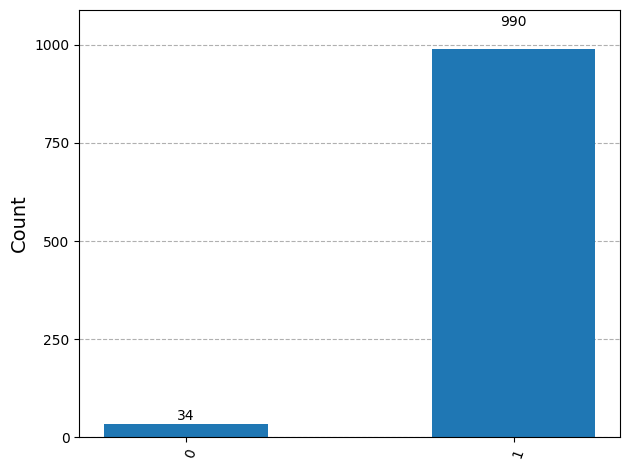

In [24]:
plot_histogram(pop_echo[5])

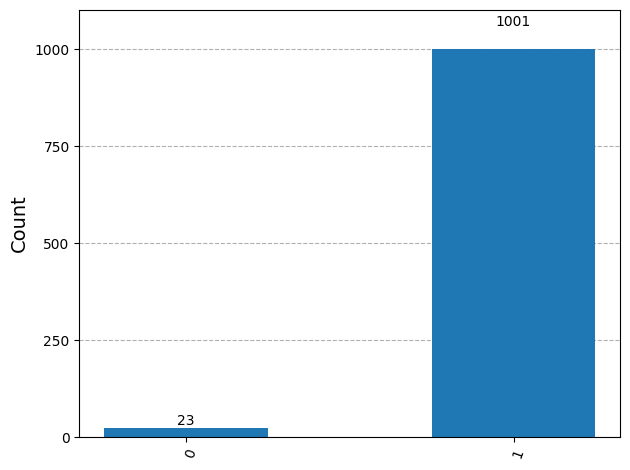

In [25]:
plot_histogram(pop_Ramsey[5])

In [ ]:
## This qubit refocus on the correct state in real QPU

# IBMQ implementation
---
Above I implemented the dynamical decoupling sequence by "hand"

Qiskit libraries of today offer an automated way to do it. 

![SegmentLocal](DD.gif "segment")


In [ ]:
estimator = Estimator(mode=backend)
estimator.options.dynamical_decoupling.enable = True
estimator.options.dynamical_decoupling.sequence_type = "XpXm"

# Zero-noise extrapolation (ZNE)
---

Zero-noise extrapolation (ZNE) is a technique for mitigating errors in estimating expectation values of observables. While it often improves results, it is not guaranteed to produce an unbiased result.

ZNE consists of two stages:

Noise amplification: The original quantum circuit is executed multiple times at different noise rates.

Extrapolation: The ideal result is estimated by extrapolating the noisy expectation value results to the zero-noise limit.

Both the noise amplification and extrapolation stages can be implemented in many different ways. Qiskit Runtime implements noise amplification by "digital gate folding," which means that two-qubit gates are replaced with equivalent sequences of the gate and its inverse. For example, replacing a unitary $U$ with $U U\dagger U$. 

$U$ would yield a noise amplification factor of 3. For the extrapolation, you can choose from one of several functional forms, including a linear fit or an exponential fit. The image below depicts digital gate folding on the left, and the extrapolation procedure on the right.

![SegmentLocal](zne.gif "segment")

In [ ]:
estimator = Estimator(mode=backend)
estimator.options.resilience.zne_mitigation = True
estimator.options.resilience.zne.noise_factors = (1, 3, 5)
estimator.options.resilience.zne.extrapolator = "exponential"

# Measurement Error mitigation

The effect of noise is to give us outputs that are not quite correct. The effect of noise that occurs throughout a computation will be quite complex in general, as one would have to consider how each gate transforms the effect of each error.

A simpler form of noise is that occurring during final measurement. At this point, the only job remaining in the circuit is to extract a bit string as an output. For an qubit final measurement, this means extracting one of the possible bit strings. As a simple model of the noise in this process, we can imagine that the measurement first selects one of these outputs in a perfect and noiseless manner, and then noise subsequently causes this perfect output to be randomly perturbed before it is returned to the user.

00 becomes {'10': 96, '11': 1, '01': 95, '00': 9808}\
01 becomes {'10': 2, '11': 103, '01': 9788, '00': 107}\
10 becomes {'10': 9814, '11': 90, '01': 1, '00': 95}\
11 becomes {'10': 87, '11': 9805, '01': 107, '00': 1}

This gives us the following matrix.
$$M = \begin{pmatrix} 0.9808 & 0.0107 & 0.0095 & 0.0001 \\ 0.0095 & 0.9788 & 0.0001 & 0.0107 \\
0.0096 & 0.0002 & 0.9814 & 0.0087 \\ 0.0001 & 0.0103 & 0.0090 & 0.9805 \\ \end{pmatrix} $$
\
If we now take the vector describing the perfect results for a given state, applying this matrix gives us a good approximation of the results when measurement noise is present.
$$C_{noisy} = MC_{ideal}$$
\
As an example, let's apply this process for the state $\frac{1}{\sqrt{2}}|00\rangle + \frac{1}{\sqrt{2}}|11\rangle$ with $10000$ shots:
$$\begin{pmatrix} 0.9808 & 0.0107 & 0.0095 & 0.0001 \\ 0.0095 & 0.9788 & 0.0001 & 0.0107 \\
0.0096 & 0.0002 & 0.9814 & 0.0087 \\ 0.0001 & 0.0103 & 0.0090 & 0.9805 \\ \end{pmatrix} \begin{pmatrix} 5000 \\ 0 \\
0 \\ 5000 \\ \end{pmatrix} = \begin{pmatrix} 4904.5 \\ 101 \\ 91.5 \\ 4903 \\ \end{pmatrix} $$
\
Instead of a way to transform ideal counts data into noisy data, we need a way to transform noisy data into ideal data. In linear algebra, we do this for a matrix by finding the inverse matrix,
$$M^{-1}C_{noisy} = C_{ideal}$$

# Handin

Please build a circuit for Rabi Experiment and compare the result in the ideal simulator and the quantum computer.
\
|0> -- |$R_x(\theta$)| -- |?> , 0 <= $\theta$ <= 8$\pi$, 200 grid points for ideal and 20 grid points for qpu
\
And plot your results as fllow:
\
|1> |\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|\
|0> |______________ \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\theta$